# Capstone Project: Battle of the Neighborhoods

### Analysing the districts of São Palo City (Brazil): by Eduardo Koga

#### We start the code by importing the required libraries 

In [333]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

! pip install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### We then upload a csv file containing the 97 districts of São Paulo using Pandas Dataframe

##### the list of districts were captured from wikipedia, however as there was no georeferences on the same webside, those had to be updated manually
wikipedia: https://pt.wikipedia.org/wiki/Lista_de_subprefeituras_do_munic%C3%ADpio_de_S%C3%A3o_Paulo

In [334]:
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("distritos_saopaulo.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,Regions,Boroughs,Latitude,Longitude
0,Centro,Bela Vista,-23.552128,-46.635161
1,Centro,Bom Retiro,-23.525656,-46.651618
2,Centro,Cambuci,-23.565619,-46.630160
3,Centro,Consolacao,-23.554083,-46.655463
4,Centro,Liberdade,-23.565311,-46.641115


In [335]:
# instantiate the dataframe
neighborhoods = data

In [336]:
print('The dataframe has {} Regions and {} Boroughs.'.format(
        len(neighborhoods['Regions'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 Regions and 97 Boroughs.


In [337]:
address = 'Sao Paulo City, SP'

geolocator = Nominatim(user_agent="sp_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Sao Paulo City are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Sao Paulo City are -23.5506507, -46.6333824.


#### We use folium to plot on the São Paulo City map all districts

In [338]:
# create map of São Paulo using latitude and longitude values
map_saopaulo = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, boroughs, regions in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Regions'], neighborhoods['Boroughs']):
    label = '{}, {}'.format(regions, boroughs)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='rainbow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_saopaulo)  
    
map_saopaulo

#### The code below connects to Foursquare

In [339]:
CLIENT_ID = 'WNET5ZNSB0CHPI4CUCTQV0PHFY0EP00LDT4MIVFK13ZEMEZ0' # your Foursquare ID
CLIENT_SECRET = 'WP3UWH5KQG0XH43LGDPH4ZUV34KD5PQJMYLGQLFVO2FURFMM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WNET5ZNSB0CHPI4CUCTQV0PHFY0EP00LDT4MIVFK13ZEMEZ0
CLIENT_SECRET:WP3UWH5KQG0XH43LGDPH4ZUV34KD5PQJMYLGQLFVO2FURFMM


#### Based on the first district of São Paulo found in the Neighborhood dataframe we get to know the latitude and longitude

In [340]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Boroughs'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bela Vista are -23.5521281, -46.6351612.


#### Then we we look for the 100 Fourquare venues that are 5000 meters radius to this georeference

In [341]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius =5000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=WNET5ZNSB0CHPI4CUCTQV0PHFY0EP00LDT4MIVFK13ZEMEZ0&client_secret=WP3UWH5KQG0XH43LGDPH4ZUV34KD5PQJMYLGQLFVO2FURFMM&v=20180605&ll=-23.5521281,-46.6351612&radius=5000&limit=100'

In [342]:
results = requests.get(url).json()

In [343]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [344]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Casa de Francisca,Music Venue,-23.548733,-46.634763
1,Centro Cultural Banco do Brasil (CCBB),Cultural Center,-23.547588,-46.634683
2,Praça da Liberdade,Plaza,-23.555262,-46.635325
3,Empório Azuki,Gourmet Shop,-23.555697,-46.635244
4,Kenzo Sushi,Sushi Restaurant,-23.557705,-46.636036


In [345]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [346]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### List all districts being returned from Foursqaure

In [347]:
saopaulo_venues = getNearbyVenues(names=neighborhoods['Boroughs'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Bela Vista
Bom Retiro
Cambuci
Consolacao
Liberdade
Republica
Santa Cecília
Se
Aricanduva
Carrao
Vila Formosa
Cidade Tiradentes
Ermelino Matarazzo
Ponte Rasa
Guaianases
Lajeado
Itaim Paulista
Vila Curuca
Itaquera
Cidade Lider
Jose Bonifacio
Parque do Carmo
Mooca Agua Rasa
Belem
Bras
Moóca
Pari
Tatuape
Penha
Artur Alvim
Cangaíba
Vila Matilde
Sao Mateus
Sao Rafael
Sao Miguel
Jardim Helena
Vila Jacui
Sapopemba
Vila Prudente
Sao Lucas
Casa Verde
Cachoeirinha
Limao
Brasilandia
Freguesia do O
Jaçana
Tremembé
Perus
Anhanguera
Pirituba
Jaragua
Sao Domingos
Santana
Tucuruvi
Mandaqui
Vila Maria
Vila Guilherme
Vila Medeiros
Butanta
Morumbi
Raposo Tavares
Rio Pequeno
Vila Sonia
Lapa
Barra Funda
Jaguara
Jaguare
Perdizes
Vila Leopoldina
Pinheiros
Alto de Pinheiros
Itaim Bibi
Jardim Paulista
Pinheiros
Campo Limpo
Capao Redondo
Vila Andrade
Capela do Socorro Cidade Dutra
Grajau
Socorro
Cidade Ademar
Pedreira
Ipiranga
Sacoma
Jabaquara
MBoi Mirim
Jardim Angela
Jardim Sao Luis
Parelheiros
Marsilac
Santo A

### Then get to know the number of venues considered in the analysis

In [348]:
print(saopaulo_venues.shape)
saopaulo_venues.head()

(9376, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bela Vista,-23.552128,-46.635161,Casa de Francisca,-23.548733,-46.634763,Music Venue
1,Bela Vista,-23.552128,-46.635161,Centro Cultural Banco do Brasil (CCBB),-23.547588,-46.634683,Cultural Center
2,Bela Vista,-23.552128,-46.635161,Praça da Liberdade,-23.555262,-46.635325,Plaza
3,Bela Vista,-23.552128,-46.635161,Empório Azuki,-23.555697,-46.635244,Gourmet Shop
4,Bela Vista,-23.552128,-46.635161,Kenzo Sushi,-23.557705,-46.636036,Sushi Restaurant


In [349]:
saopaulo_venues.groupby('Neighborhood').count()
saopaulo_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bela Vista,-23.552128,-46.635161,Casa de Francisca,-23.548733,-46.634763,Music Venue
1,Bela Vista,-23.552128,-46.635161,Centro Cultural Banco do Brasil (CCBB),-23.547588,-46.634683,Cultural Center
2,Bela Vista,-23.552128,-46.635161,Praça da Liberdade,-23.555262,-46.635325,Plaza
3,Bela Vista,-23.552128,-46.635161,Empório Azuki,-23.555697,-46.635244,Gourmet Shop
4,Bela Vista,-23.552128,-46.635161,Kenzo Sushi,-23.557705,-46.636036,Sushi Restaurant


In [350]:
print('There are {} uniques categories.'.format(len(saopaulo_venues['Venue Category'].unique())))

There are 300 uniques categories.


### Reorganize pandas dataframe to show Neighborhoods in lines, categories in columns and the quantities as values 

In [351]:
# one hot encoding
saopaulo_onehot = pd.get_dummies(saopaulo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
saopaulo_onehot['Neighborhood'] = saopaulo_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [saopaulo_onehot.columns[-1]] + list(saopaulo_onehot.columns[:-1])
saopaulo_onehot= saopaulo_onehot[fixed_columns]

saopaulo_onehot.head()

,Yoga Studio,ATM,Acai House,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baiano Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Butcher,Café,Campground,Candy Store,Car Wash,Central Brazilian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Electronics Store,Empanada Restaurant,Escape Room,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Northeastern Brazilian Restaurant,Northern Brazilian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Piadineria,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,Southeastern Brazilian Restaurant,Southern Brazilian Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Stoop Sale,Street Art,Student Center,Supermarket,Sushi Restaurant,Swim School,Swiss Restaurant,Taco Place,Tapiocaria,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toll Plaza,Tour Provider,Toy / Ga

In [352]:
saopaulo_onehot.shape

(9376, 300)

### Show in a sorted way which categories have more venues in the São Paulo City, regardless the neighborhood

In [353]:
saopaulo_venues_categories= saopaulo_venues.drop(['Neighborhood','Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue'], axis=1)
saopaulo_venues_categories2 = saopaulo_venues_categories.groupby('Venue Category').size().reset_index(name='Counts')

# sort Brand - descending order
saopaulo_venues_categories2.sort_values(by=['Counts'], inplace=True, ascending=False)

#saopaulo_venues_categories2.head(20)

df_raw = saopaulo_venues_categories2.drop(saopaulo_venues_categories2[(saopaulo_venues_categories2.Counts < 100)].index)

# Rename the columns of df2_melted: df2_tidy
df_raw2 = df_raw.rename(columns = {'Venue Category': 'Venue_Category', 'Counts': 'Qtty'}, inplace = False)


df_raw2.head(30)

,Venue_Category,Qtty
24,Bakery,497
214,Pizza Place,476
126,Gym / Fitness Center,394
81,Dessert Shop,310
40,Brazilian Restaurant,309
147,Ice Cream Shop,279
25,Bar,274
231,Restaurant,250
125,Gym,249
151,Italian Restaurant,240


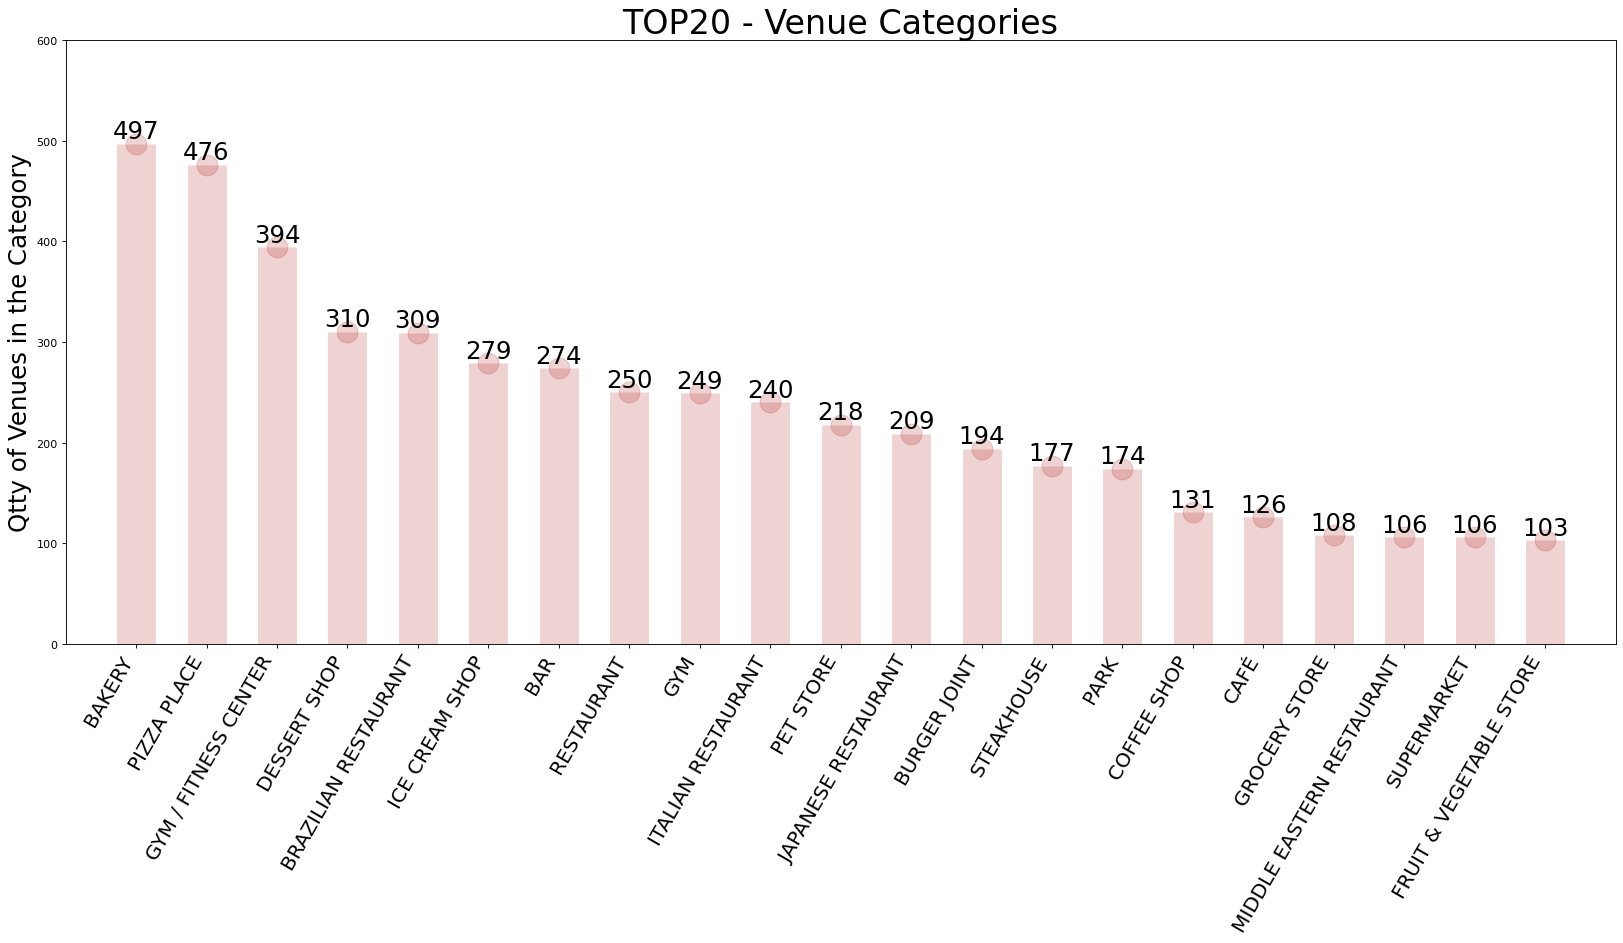

In [354]:
#pip install brewer2mpl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

# Prepare Data
df_chart = df_raw2[['Qtty', 'Venue_Category']].groupby('Venue_Category').apply(lambda x: x.mean())
df_chart.sort_values('Qtty', inplace=True, ascending=False)
df_chart.reset_index(inplace=True)

# Draw plot
fig, ax = plt.subplots(figsize=(25,10), dpi= 80)
ax.vlines(x=df_chart.index, ymin=0, ymax=df_chart.Qtty, color='firebrick', alpha=0.2, linewidth=35)
ax.scatter(x=df_chart.index, y=df_chart.Qtty, s=350, color='firebrick', alpha=0.2)

# Title, Label, Ticks and Ylim
ax.set_title('TOP20 - Venue Categories', fontdict={'size':30})
ax.set_ylabel('Qtty of Venues in the Category', fontdict={'size':22})
ax.set_xticks(df_chart.index)
ax.set_xticklabels(df_chart.Venue_Category.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':18})
ax.set_ylim(0, 600)

# Annotate
for row in df_chart.itertuples():
    ax.text(row.Index, row.Qtty+.5, s=round(row.Qtty), horizontalalignment= 'center', verticalalignment='bottom', fontsize=22)

plt.show()

In [355]:
saopaulo_grouped = saopaulo_onehot.groupby('Neighborhood').mean().reset_index()
saopaulo_grouped.head()

,Neighborhood,Yoga Studio,ATM,Acai House,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baiano Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Butcher,Café,Campground,Candy Store,Car Wash,Central Brazilian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Electronics Store,Empanada Restaurant,Escape Room,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nightclub,Northeastern Brazilian Restaurant,Northern Brazilian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Piadineria,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,Southeastern Brazilian Restaurant,Southern Brazilian Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Stoop Sale,Street Art,Student Center,Supermarket,Sushi Restaurant,Swim School,Swiss Restaurant,Taco Place,Tapiocaria,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toll Plaza,Tour Provider,Toy / Ga

In [356]:
saopaulo_grouped.shape

(95, 300)

### Show the top 3 venues by Neighborhood based on their frquencies

In [357]:
num_top_venues = 3

for hood in saopaulo_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp =  saopaulo_grouped[ saopaulo_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [358]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [359]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = saopaulo_grouped['Neighborhood']

for ind in np.arange(saopaulo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(saopaulo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(15)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Alto de Pinheiros,Italian Restaurant,Ice Cream Shop,Coffee Shop
1,Anhanguera,Fast Food Restaurant,Gym / Fitness Center,Bakery
2,Aricanduva,Pizza Place,Dessert Shop,Gym / Fitness Center
3,Artur Alvim,Pizza Place,Bakery,Bar
4,Barra Funda,Pizza Place,Brazilian Restaurant,Ice Cream Shop
5,Bela Vista,Brazilian Restaurant,Ice Cream Shop,Restaurant
6,Belem,Italian Restaurant,Dessert Shop,Bar
7,Bom Retiro,Pizza Place,Japanese Restaurant,Theater
8,Bras,Pizza Place,Steakhouse,Ice Cream Shop
9,Brasilandia,Pizza Place,Gym / Fitness Center,Gym


<function matplotlib.pyplot.show(close=None, block=None)>

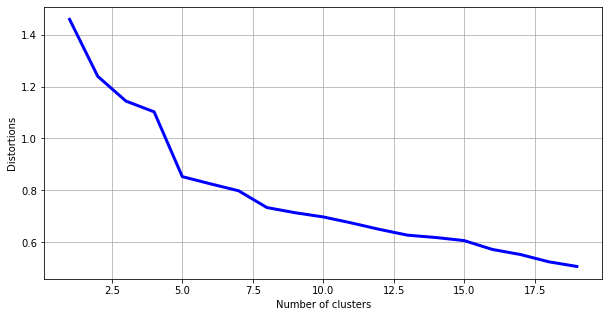

In [360]:
saopaulo_grouped_clustering = saopaulo_grouped.drop('Neighborhood', 1)

distortions = []

K = range(1,20)
for k in K:
    kmean =  KMeans(n_clusters=k,random_state=0, n_init = 1,  max_iter=500)
    kmean.fit(saopaulo_grouped_clustering)
    
    distortions.append(kmean.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, distortions,color='blue', linewidth='3')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.grid()
plt.show


In [361]:
#! pip install kneed
#import matplotlib.pyplot as plt
from kneed import DataGenerator, KneeLocator

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
kl.elbow


8

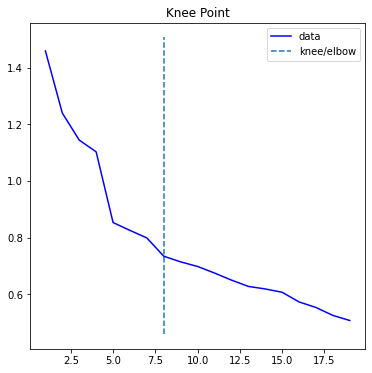

In [362]:
kl.plot_knee()

### Determine the number of clusters to be used

In [363]:
# set number of clusters
kclusters = 8

saopaulo_grouped_clustering = saopaulo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(saopaulo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 6, 0, 6, 1, 1, 7, 1, 1, 6], dtype=int32)

In [364]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

saopaulo_merged = neighborhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
saopaulo_merged = saopaulo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Boroughs')

# drop rows when cluster is NaN
saopaulo_merged.dropna(how='any', inplace=True)
#saopaulo_merged. = df.reset_index(drop=True)

# converting 'Weight' from float to int 
saopaulo_merged['Cluster Labels'] = saopaulo_merged['Cluster Labels'].astype(int) 

saopaulo_merged.head() # check the last columns!

,Regions,Boroughs,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Centro,Bela Vista,-23.552128,-46.635161,1,Brazilian Restaurant,Ice Cream Shop,Restaurant
1,Centro,Bom Retiro,-23.525656,-46.651618,1,Pizza Place,Japanese Restaurant,Theater
2,Centro,Cambuci,-23.565619,-46.630160,1,Ice Cream Shop,Pizza Place,Brazilian Restaurant
3,Centro,Consolacao,-23.554083,-46.655463,1,Ice Cream Shop,Pizza Place,Brazilian Restaurant
4,Centro,Liberdade,-23.565311,-46.641115,1,Pizza Place,Brazilian Restaurant,Ice Cream Shop


### Sho the districts organized based on the cluster the fall in (by similarity)

In [365]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(saopaulo_merged['Latitude'], saopaulo_merged['Longitude'], saopaulo_merged['Boroughs'], saopaulo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster -1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.50).add_to(map_clusters)
        
legend_name = 'test'
      
map_clusters

In [366]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] == 0, saopaulo_merged.columns[[1] + list(range(5, saopaulo_merged.shape[1]))]]


,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
8,Aricanduva,Pizza Place,Dessert Shop,Gym / Fitness Center
9,Carrao,Dessert Shop,Ice Cream Shop,Burger Joint
10,Vila Formosa,Dessert Shop,Gym / Fitness Center,Italian Restaurant
27,Tatuape,Bakery,Dessert Shop,Gym / Fitness Center
28,Penha,Bakery,Dessert Shop,Brazilian Restaurant
31,Vila Matilde,Dessert Shop,Brazilian Restaurant,Burger Joint
37,Sapopemba,Pizza Place,Dessert Shop,Gym / Fitness Center
39,Sao Lucas,Dessert Shop,Pizza Place,Bakery
42,Limao,Dessert Shop,Italian Restaurant,Bar
44,Freguesia do O,Bakery,Brazilian Restaurant,Bar


In [367]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] ==1 , saopaulo_merged.columns[[1] + list(range(5, saopaulo_merged.shape[1]))]]

,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bela Vista,Brazilian Restaurant,Ice Cream Shop,Restaurant
1,Bom Retiro,Pizza Place,Japanese Restaurant,Theater
2,Cambuci,Ice Cream Shop,Pizza Place,Brazilian Restaurant
3,Consolacao,Ice Cream Shop,Pizza Place,Brazilian Restaurant
4,Liberdade,Pizza Place,Brazilian Restaurant,Ice Cream Shop
5,Republica,Brazilian Restaurant,Ice Cream Shop,Pizza Place
6,Santa Cecília,Ice Cream Shop,Brazilian Restaurant,Pizza Place
7,Se,Brazilian Restaurant,Ice Cream Shop,Restaurant
24,Bras,Pizza Place,Steakhouse,Ice Cream Shop
25,Moóca,Ice Cream Shop,Pizza Place,Sandwich Place


In [368]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] ==2 , saopaulo_merged.columns[[1] + list(range(5, saopaulo_merged.shape[1]))]]

,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
11,Cidade Tiradentes,Pizza Place,Bakery,Gym
16,Itaim Paulista,Bakery,Pizza Place,Gym
21,Parque do Carmo,Bakery,Pizza Place,Gym
32,Sao Mateus,Bakery,Pizza Place,Dessert Shop
33,Sao Rafael,Bakery,Brazilian Restaurant,Pizza Place
41,Cachoeirinha,Gym / Fitness Center,Brazilian Restaurant,Bakery
45,Jaçana,Bakery,Gym / Fitness Center,Pizza Place
47,Perus,Bakery,Gym / Fitness Center,Pizza Place
49,Pirituba,Bakery,Gym / Fitness Center,Park
50,Jaragua,Bakery,Gym / Fitness Center,Park


In [369]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] == 3, saopaulo_merged.columns[[1] + list(range(5, saopaulo_merged.shape[1]))]]

,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
89,Marsilac,Market,Other Great Outdoors,Campground


In [370]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] == 4, saopaulo_merged.columns[[1] + list(range(5, saopaulo_merged.shape[1]))]]

,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
58,Butanta,Italian Restaurant,Ice Cream Shop,Coffee Shop
59,Morumbi,Coffee Shop,Gym / Fitness Center,Middle Eastern Restaurant
69,Pinheiros,Italian Restaurant,Ice Cream Shop,Dessert Shop
70,Alto de Pinheiros,Italian Restaurant,Ice Cream Shop,Coffee Shop
71,Itaim Bibi,Italian Restaurant,Ice Cream Shop,Argentinian Restaurant
72,Jardim Paulista,Ice Cream Shop,Italian Restaurant,Brazilian Restaurant
73,Pinheiros,Italian Restaurant,Ice Cream Shop,Dessert Shop
77,Capela do Socorro Cidade Dutra,Coffee Shop,Ice Cream Shop,Italian Restaurant
91,Campo Belo,Ice Cream Shop,Bar,Coffee Shop
94,Moema,Italian Restaurant,Ice Cream Shop,Restaurant


In [371]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] == 5, saopaulo_merged.columns[[1] + list(range(5, saopaulo_merged.shape[1]))]]

,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
51,Sao Domingos,Bakery,Gym / Fitness Center,Dessert Shop
60,Raposo Tavares,Bakery,Pizza Place,Steakhouse
62,Vila Sonia,Middle Eastern Restaurant,Pizza Place,Bakery
74,Campo Limpo,Bakery,Dessert Shop,Pizza Place
76,Vila Andrade,Bakery,Middle Eastern Restaurant,Gym
79,Socorro,Pizza Place,Bakery,Pet Store
83,Sacoma,Dessert Shop,Ice Cream Shop,Restaurant
84,Jabaquara,Dessert Shop,Bakery,Ice Cream Shop
87,Jardim Sao Luis,Bakery,Pet Store,Mineiro Restaurant
90,Santo Amaro,Pizza Place,Gym / Fitness Center,Italian Restaurant


In [372]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] == 6, saopaulo_merged.columns[[1] + list(range(5, saopaulo_merged.shape[1]))]]

,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
12,Ermelino Matarazzo,Brazilian Restaurant,Pizza Place,Bar
13,Ponte Rasa,Gym / Fitness Center,Pizza Place,Bakery
14,Guaianases,Bar,Brazilian Restaurant,Bakery
15,Lajeado,Bakery,Bar,Pizza Place
17,Vila Curuca,Bakery,Japanese Restaurant,Pizza Place
18,Itaquera,Pizza Place,Bakery,Bar
19,Cidade Lider,Pizza Place,Bakery,Gym / Fitness Center
20,Jose Bonifacio,Bakery,Bar,Pizza Place
29,Artur Alvim,Pizza Place,Bakery,Bar
30,Cangaíba,Bakery,Gym / Fitness Center,Japanese Restaurant


In [373]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] == 7, saopaulo_merged.columns[[1] + list(range(5, saopaulo_merged.shape[1]))]]

,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
22,Mooca Agua Rasa,Pizza Place,Italian Restaurant,Bar
23,Belem,Italian Restaurant,Dessert Shop,Bar
26,Pari,Japanese Restaurant,Theater,Pizza Place
38,Vila Prudente,Bar,Pizza Place,Italian Restaurant
40,Casa Verde,Bar,Japanese Restaurant,Italian Restaurant
46,Tremembé,Bakery,Burger Joint,Gym / Fitness Center
52,Santana,Pizza Place,Bar,Japanese Restaurant
53,Tucuruvi,Bakery,Bar,Pizza Place
54,Mandaqui,Bakery,Burger Joint,Bar
55,Vila Maria,Bar,Burger Joint,Italian Restaurant


In [374]:
len(saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] == 0])


15

In [375]:
Clusters = saopaulo_merged.groupby('Cluster Labels').size().reset_index(name='Counts')

# converting 'Weight' from float to int 
Clusters['Cluster Labels'] = Clusters['Cluster Labels'].astype(str) 

# sort - descending order
Clusters.sort_values(by=['Counts'], inplace=True, ascending=False)

Clusters

,Cluster Labels,Counts
6,6,17
2,2,16
0,0,15
5,5,13
1,1,12
7,7,12
4,4,11
3,3,1


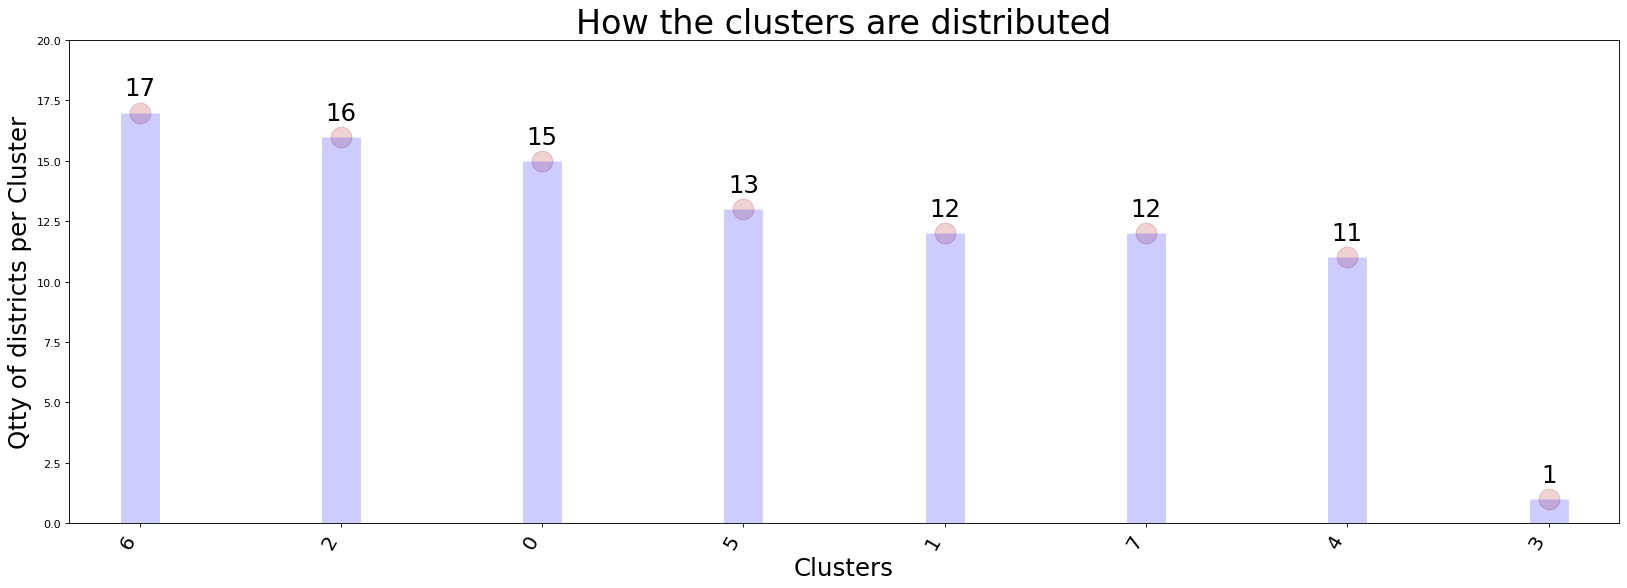

In [376]:
# Rename the columns of df2_melted: df2_tidy
Clusters2 = Clusters.rename(columns = {'Cluster Labels': 'Cluster_Labels', 'Counts': 'Qtty'}, inplace = False)

# sort - descending order
Clusters2.sort_values(by=['Qtty'], inplace=True, ascending=False)
Clusters2.reset_index(inplace=True)

# Draw plot
fig, ax = plt.subplots(figsize=(25,8), dpi= 80)
ax.vlines(x=Clusters2.index, ymin=0, ymax=Clusters2.Qtty, color='blue', alpha=0.2, linewidth=35)
ax.scatter(x=Clusters2.index, y=Clusters2.Qtty, s=350, color='firebrick', alpha=0.2)

# Title, Label, Ticks and Ylim
ax.set_title('How the clusters are distributed', fontdict={'size':30})
ax.set_ylabel('Qtty of districts per Cluster', fontdict={'size':22})
ax.set_xticks(Clusters2.index)
ax.set_xlabel('Clusters', fontdict={'size':22})
ax.set_xticklabels(Clusters2.Cluster_Labels.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':18})
ax.set_ylim(0, 20)

# Annotate
for row in Clusters2.itertuples():
    ax.text(row.Index, row.Qtty+.5, s=round(row.Qtty), horizontalalignment= 'center', verticalalignment='bottom', fontsize=22)

plt.show()